In [ ]:
import numpy as np
from scipy.io.wavfile import write
import os
import librosa
import matplotlib.pyplot as plt
# Usaremos PyTorch y fastai en lugar de TensorFlow
import torch
from fastai.vision.all import *
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [9]:
# DEFINICIÓN DE PARÁMETROS

DATASET_DIR = "datasetPrueba"           # Directorio donde se guardará el dataset generado
os.makedirs(DATASET_DIR, exist_ok=True) # Crea el directorio si no existe (exist_ok=True evita error si ya existe)

# Parámetros de audio
sample_rate = 44100  
duration = 1.0       # Duración de cada muestra

# Lista de frecuencias (en Hz)
frequencies = [220, 330, 440, 550, 660, 770, 880, 990, 1100, 1320] 

# Tipos de ondas que se generarán
wave_types = ["sine", "square", "sawtooth", "triangle", "noise"]

# Función que genera la forma de onda según el tipo, frecuencia y duración
def generate_waveform(wave_type, freq, duration, sample_rate):
    # Vector de tiempo desde 0 hasta duración, con pasos según la frecuencia de muestreo
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

    # Generación de diferentes tipos de onda
    if wave_type == "sine":       
        wave = np.sin(2 * np.pi * freq * t)
    elif wave_type == "square":    
        wave = np.sign(np.sin(2 * np.pi * freq * t))
    elif wave_type == "sawtooth":  
        wave = 2 * (t * freq - np.floor(0.5 + t * freq))
    elif wave_type == "triangle":  
        wave = 2 * np.abs(2 * (t * freq - np.floor(0.5 + t * freq))) - 1
    elif wave_type == "noise":     # Ruido blanco
        wave = np.random.uniform(-1, 1, len(t))
    else:
        # Error si se pasa un tipo de onda no reconocido
        raise ValueError(f"Tipo de onda no reconocido: {wave_type}")

    return wave


In [ ]:
# Generación espectrograma para dataset

def wav_to_spectrogram_and_save(signal, sample_rate, output_path):
    stft = librosa.stft(signal)
    spectrogram = np.abs(stft)
    spectrogram_db = librosa.amplitude_to_db(spectrogram)  #lo pasamos a decibelios para poder visualizarlo

    plt.figure(figsize=(10,4))
    img = librosa.display.specshow(spectrogram_db, y_axis='log', x_axis='time', sr=sample_rate, cmap='inferno')
    #plt.show()
    
    plt.axis('off')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()
    
    return output_path


Generando dataset de sonidos...


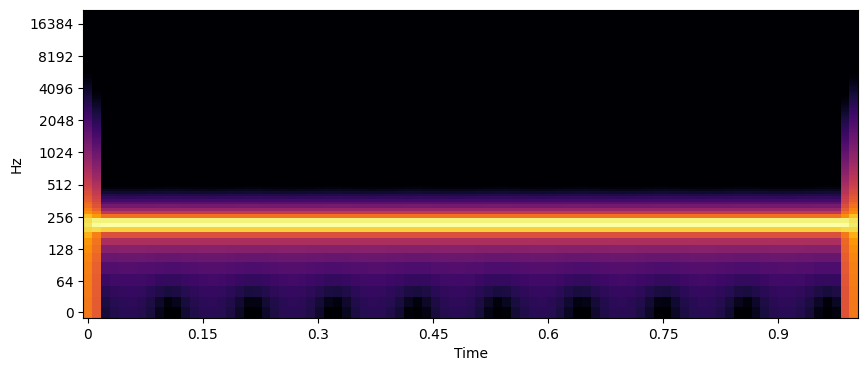

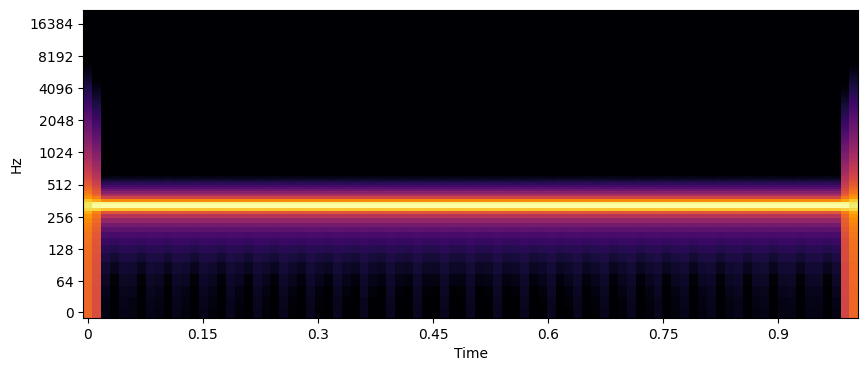

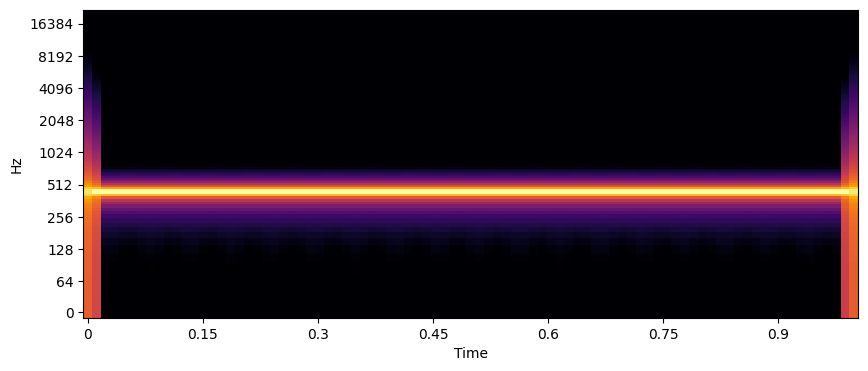

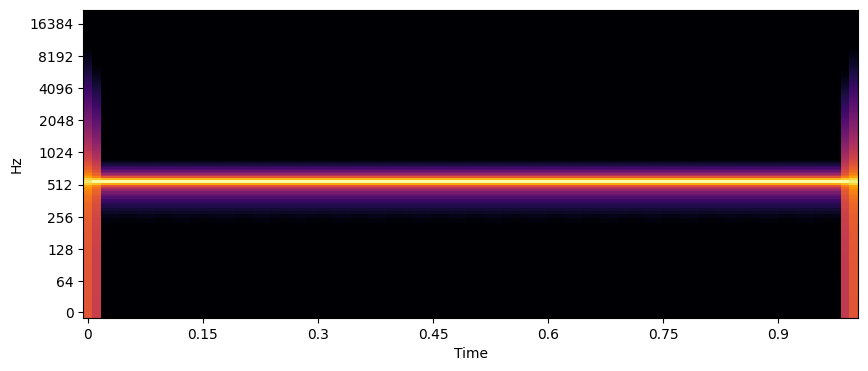

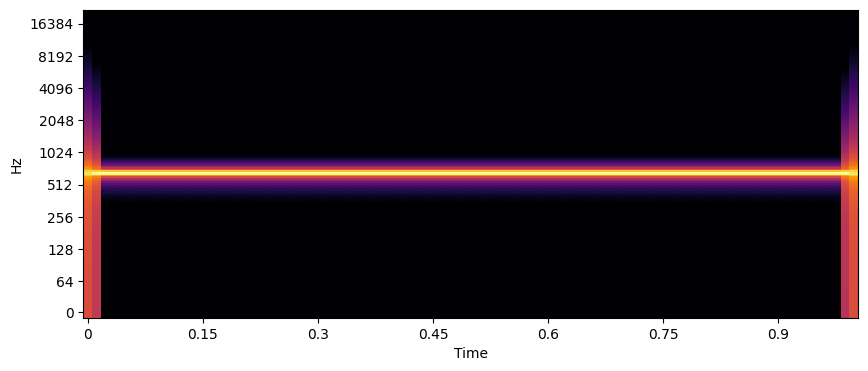

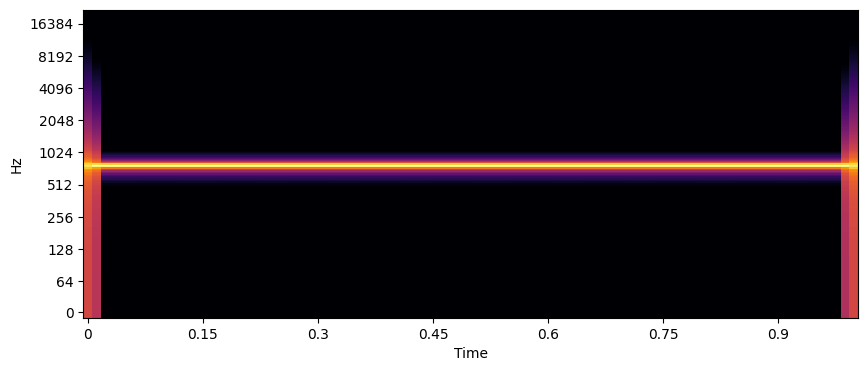

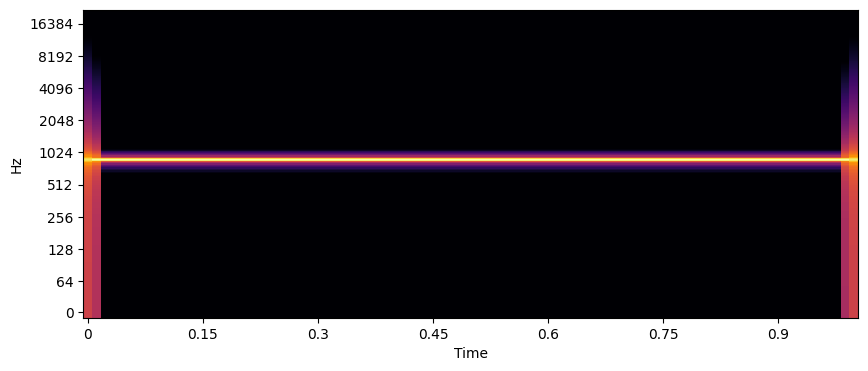

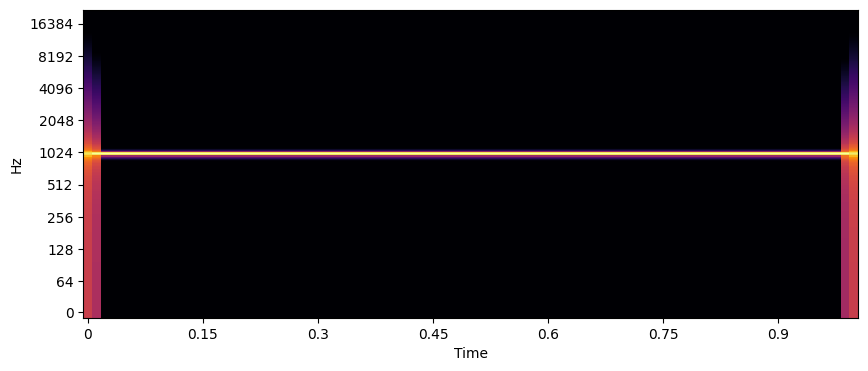

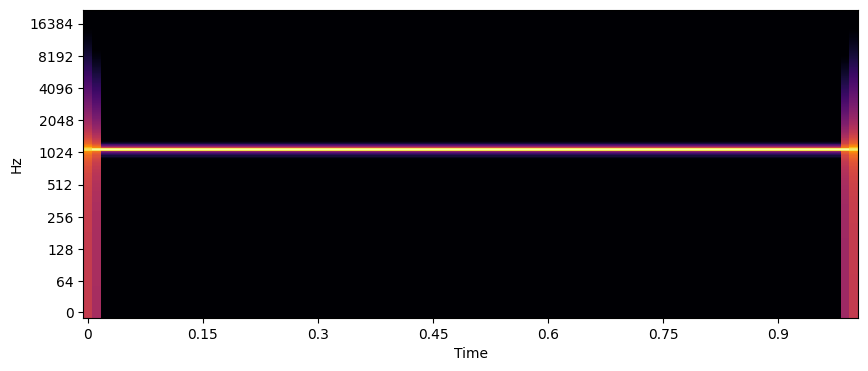

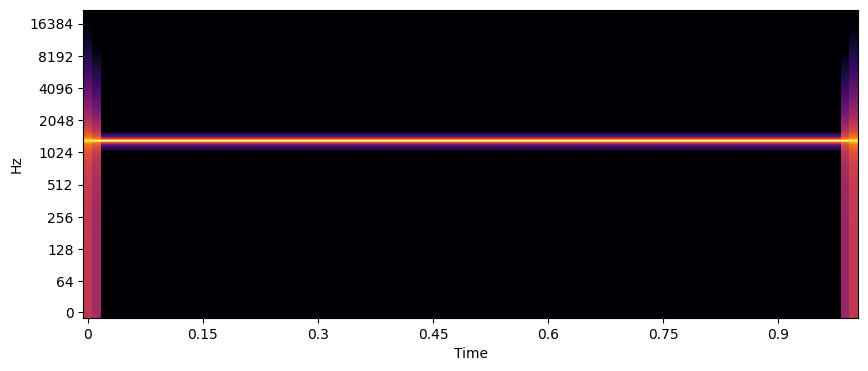

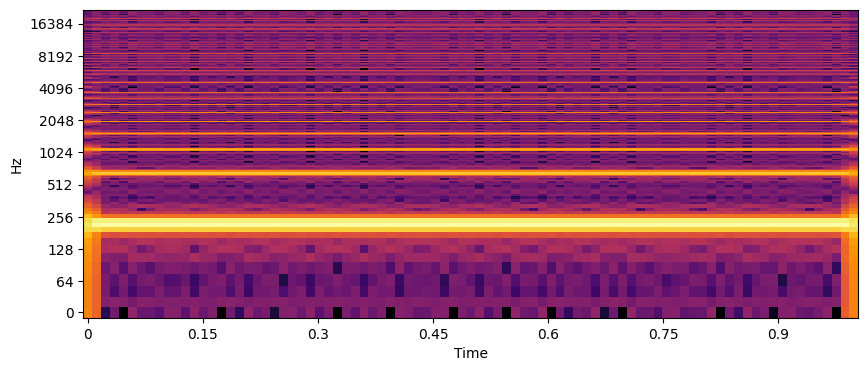

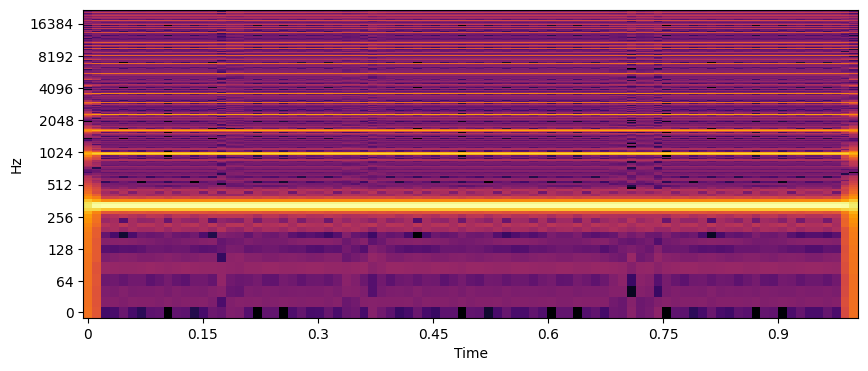

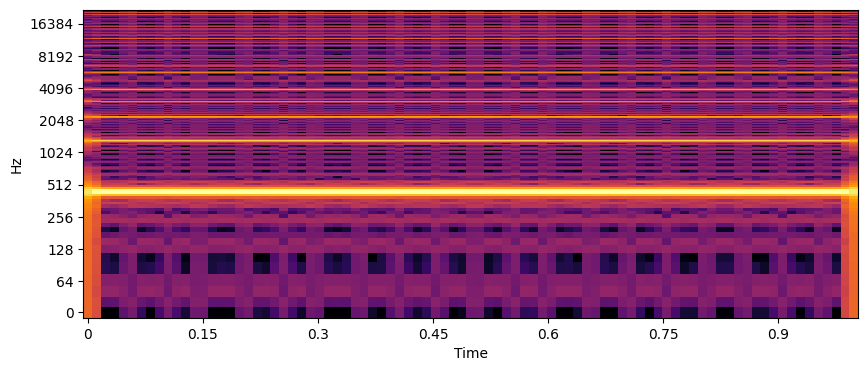

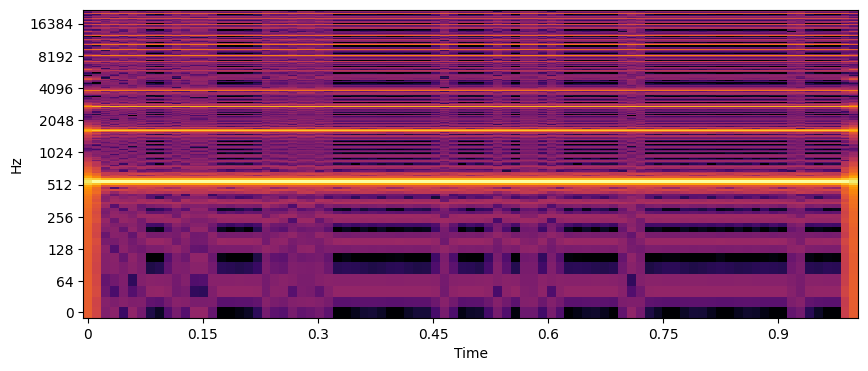

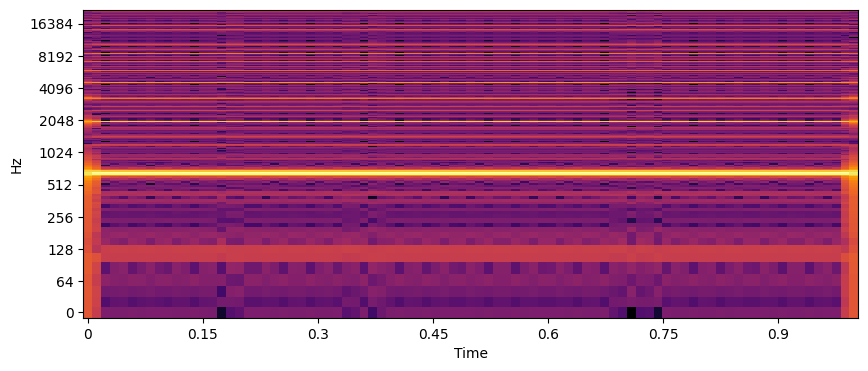

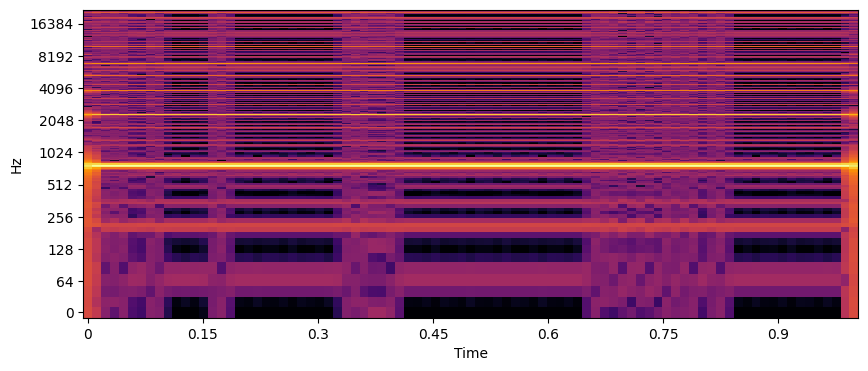

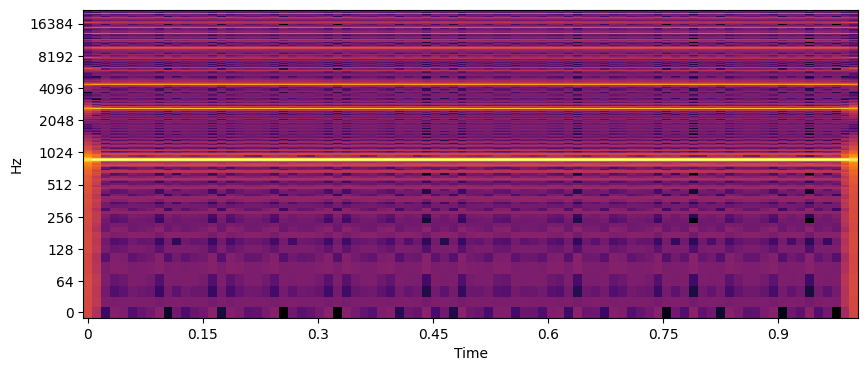

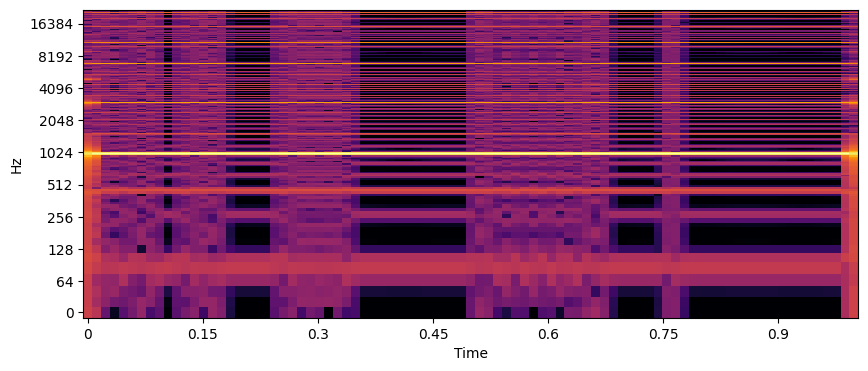

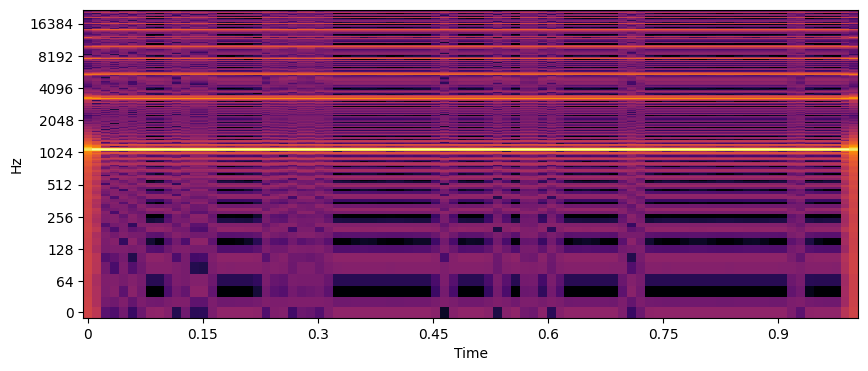

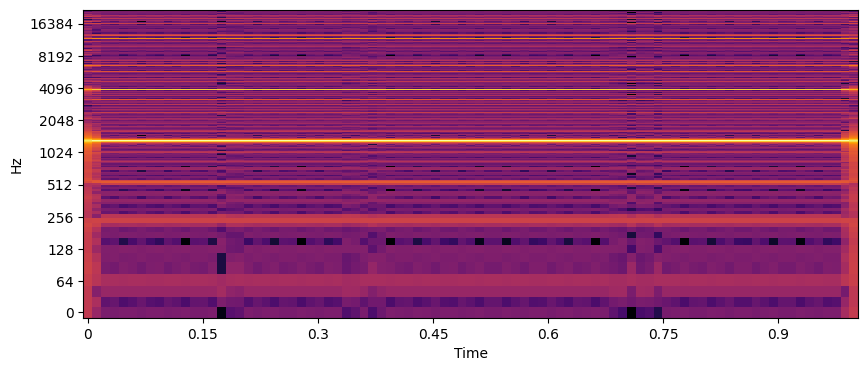

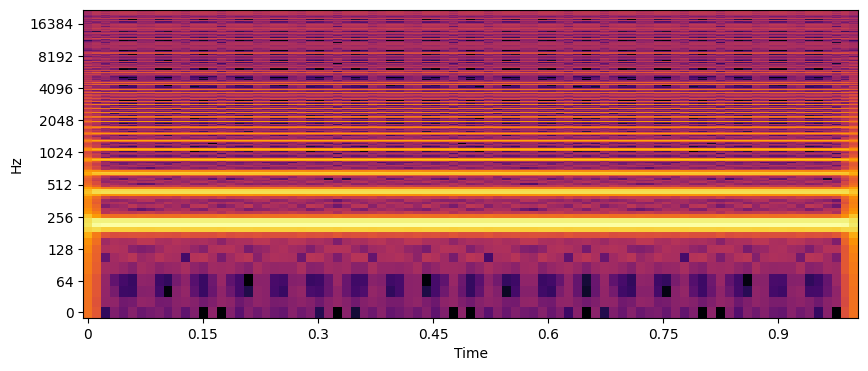

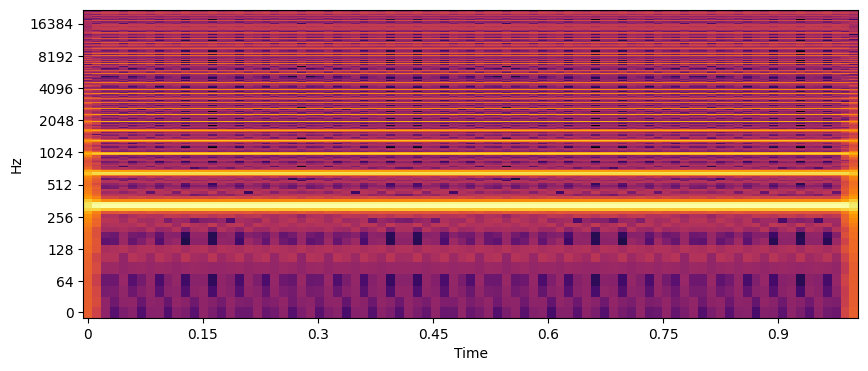

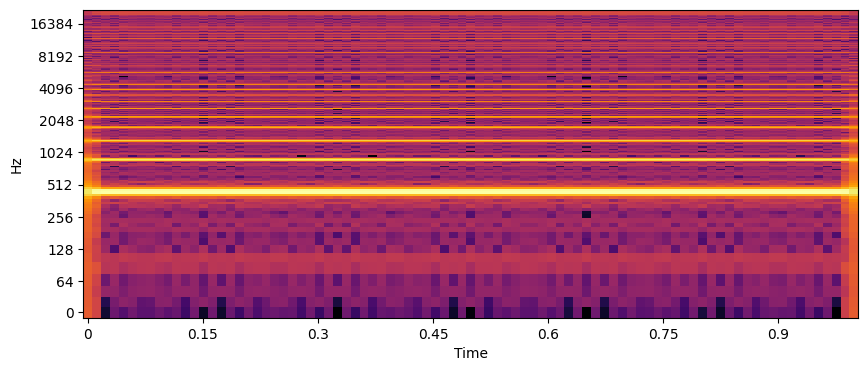

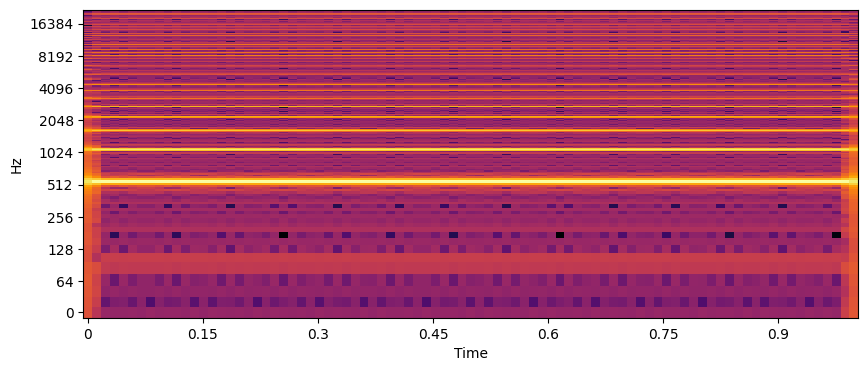

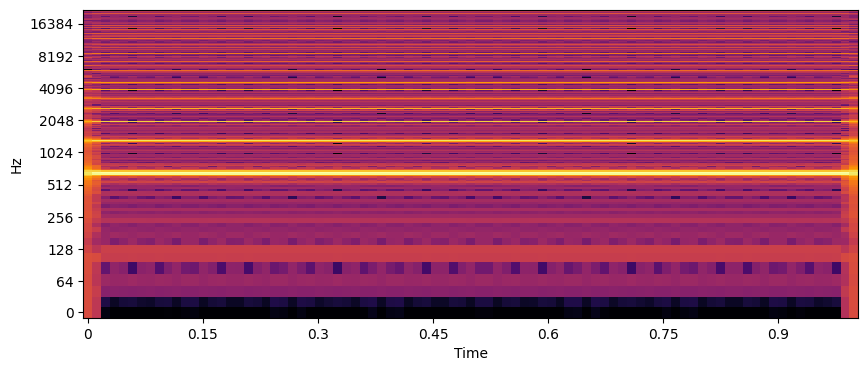

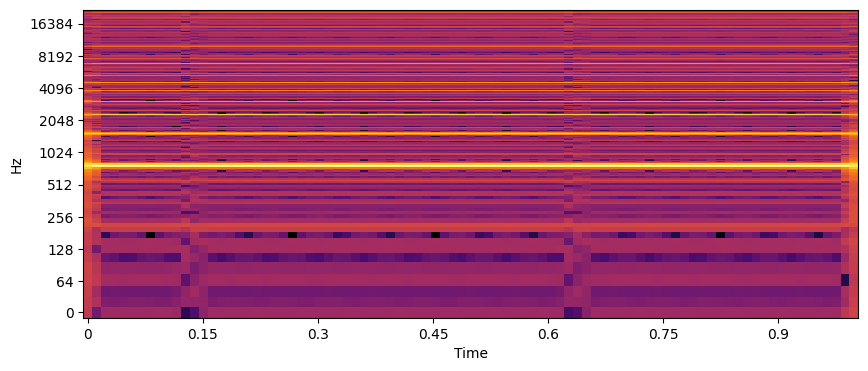

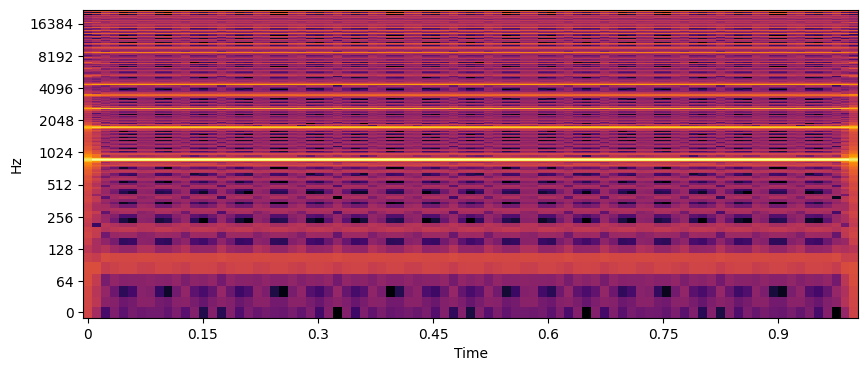

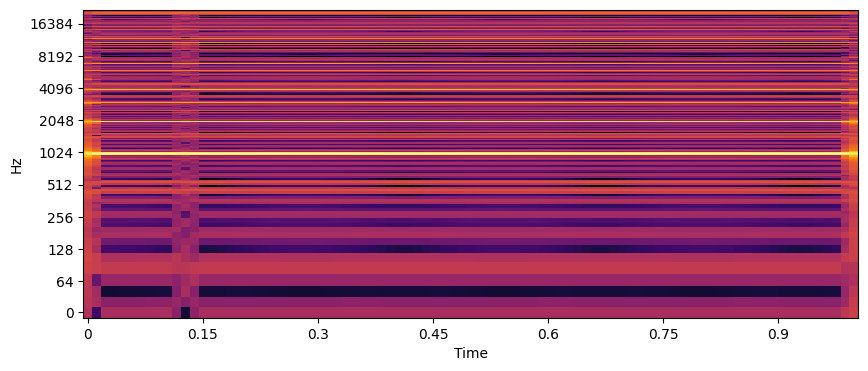

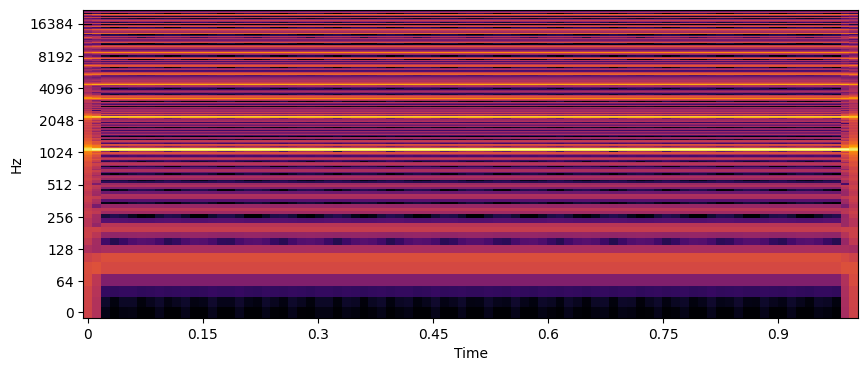

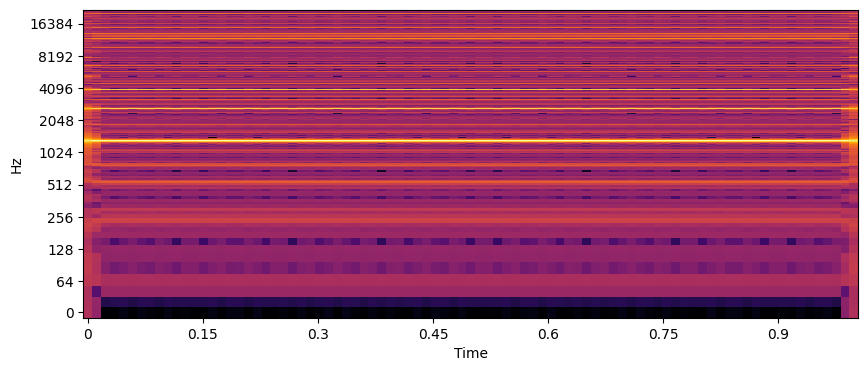

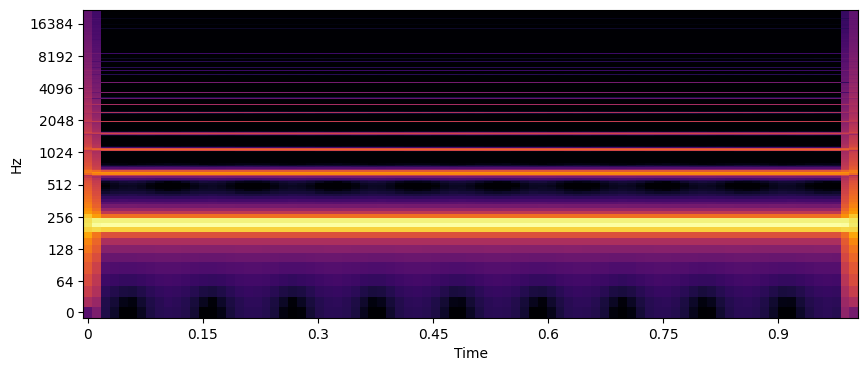

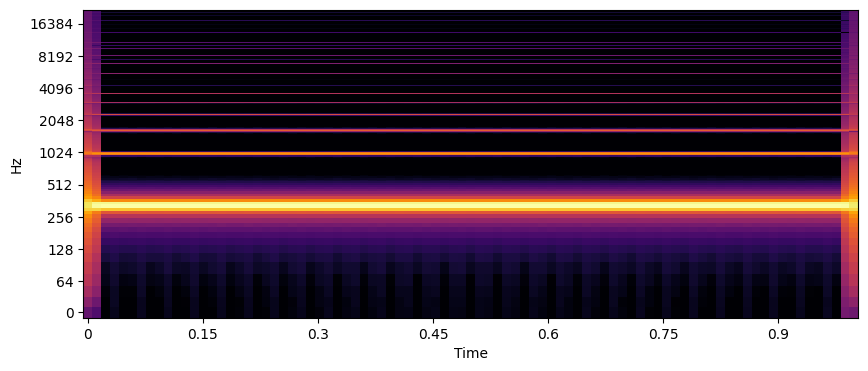

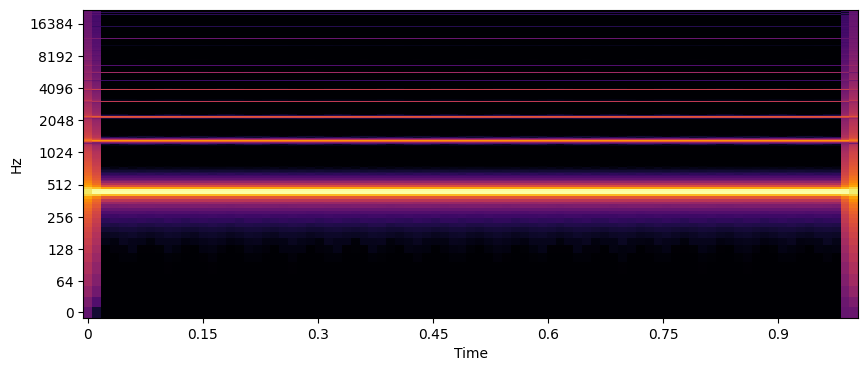

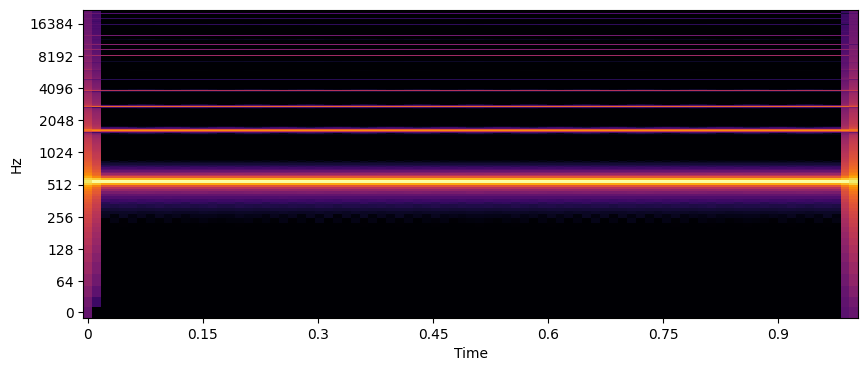

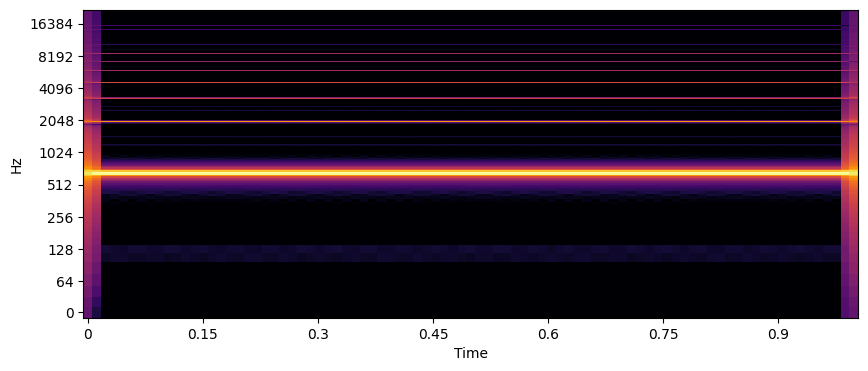

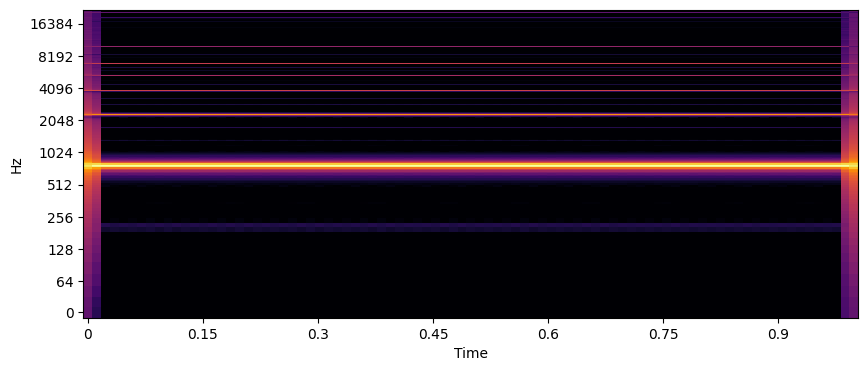

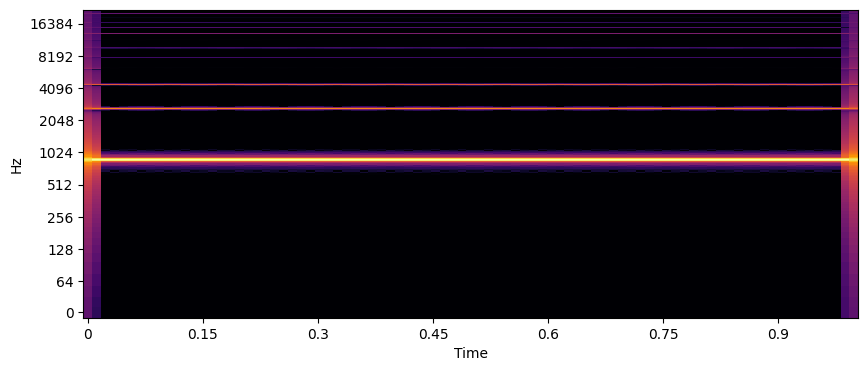

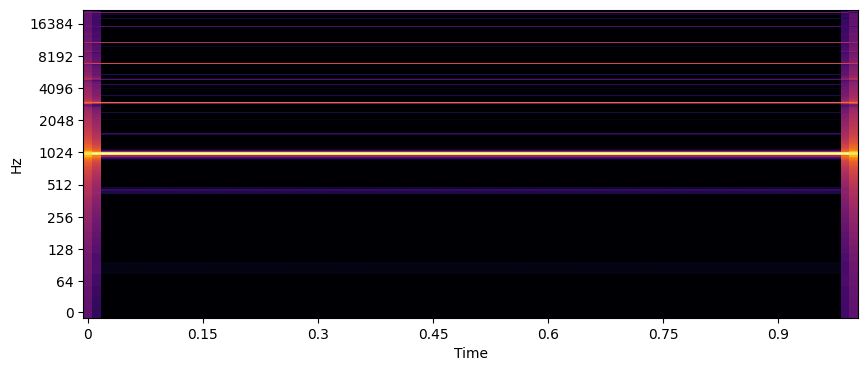

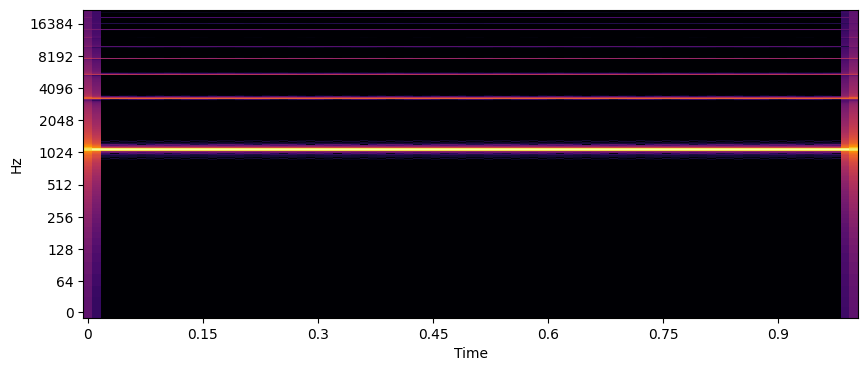

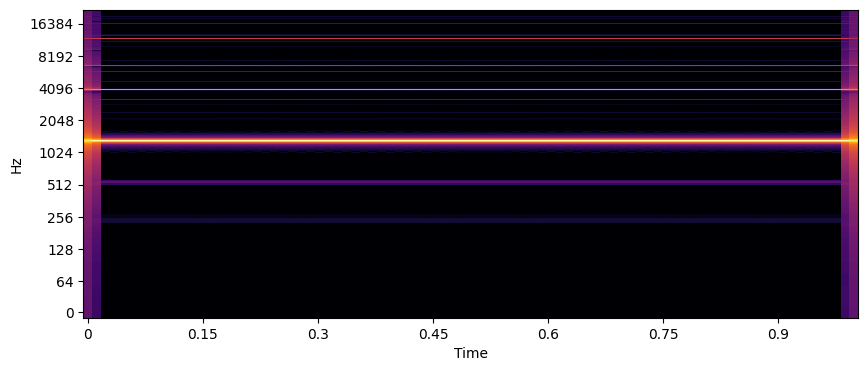

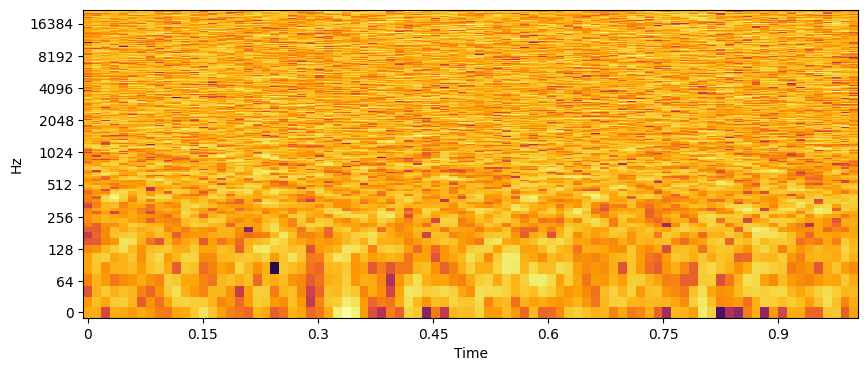

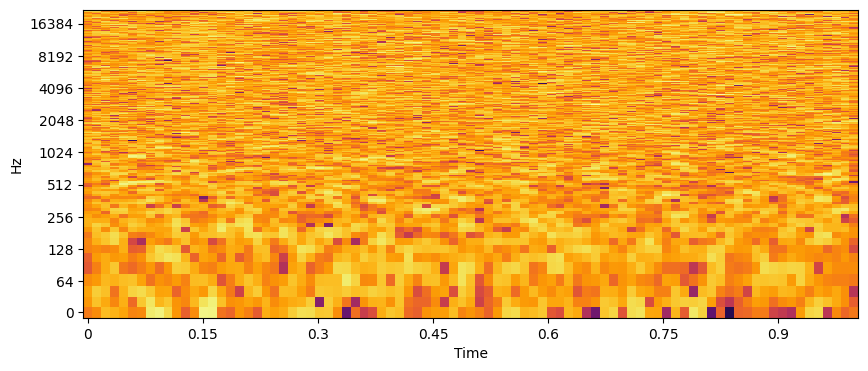

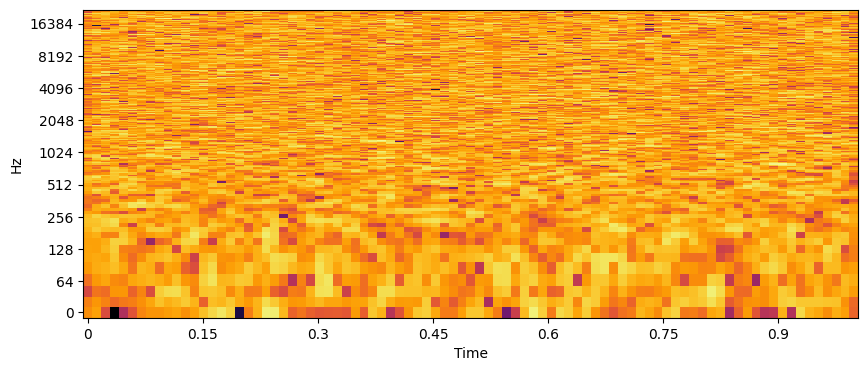

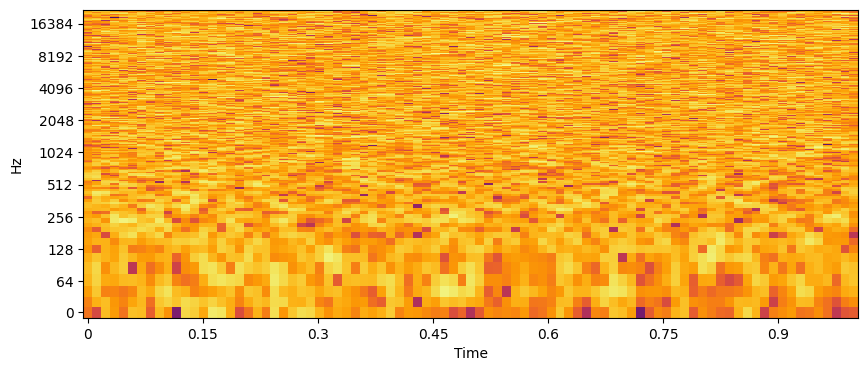

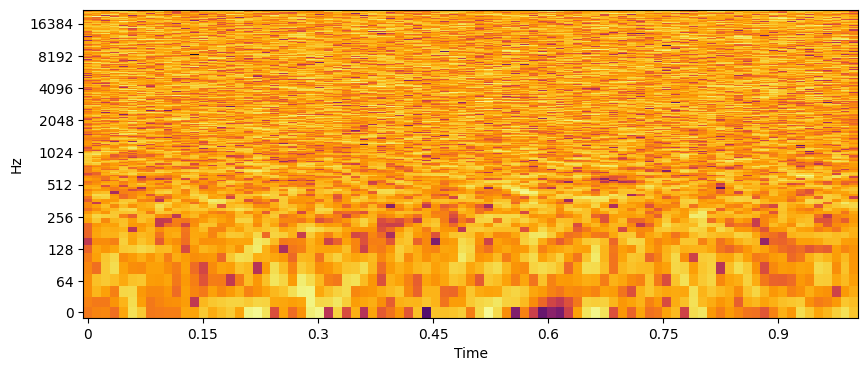

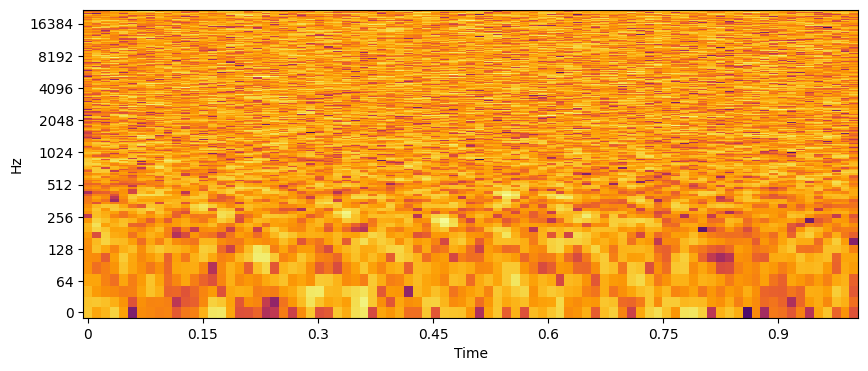

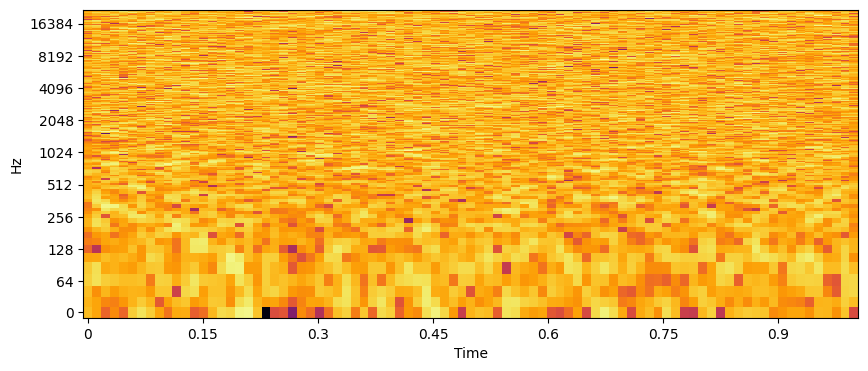

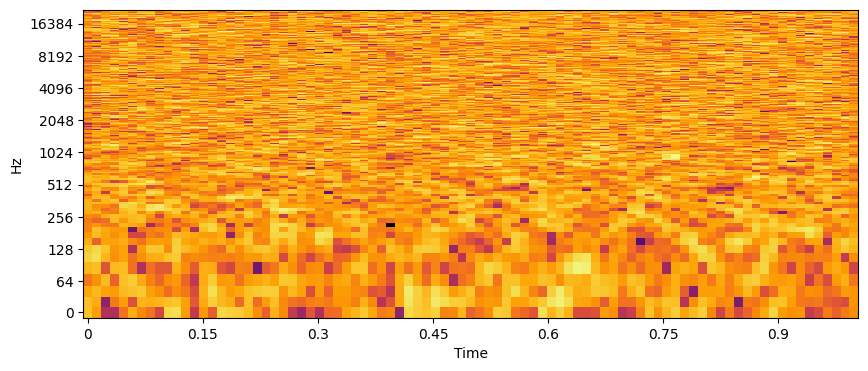

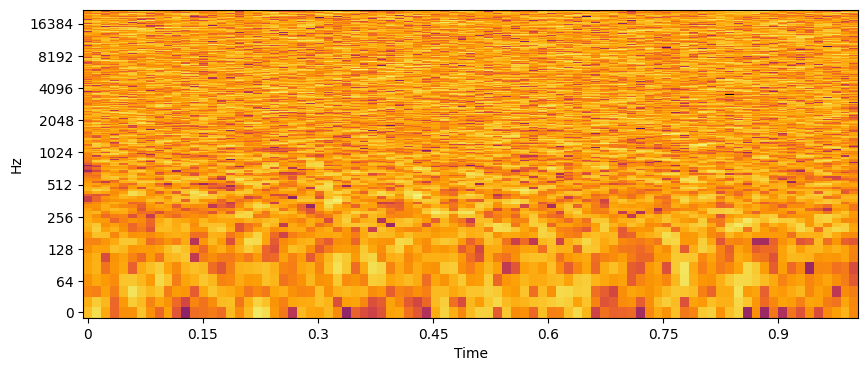

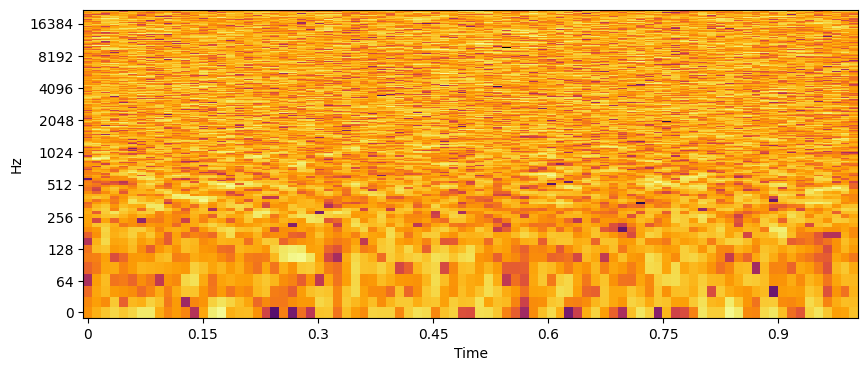

Finalizado con éxito!!! Dataset generado en: c:\Users\angel\OneDrive\Documentos\UNIVERSIDAD 4\tfg sin git\dataset\datasetPrueba


In [ ]:
# GENERACION DATASET

print("Generando dataset de sonidos...")

for wave in wave_types:
    # Crea un subdirectorio por tipo de onda
    folder = os.path.join(DATASET_DIR, wave)
    os.makedirs(folder, exist_ok=True)

    # Genera un archivo de audio para cada frecuencia
    for freq in frequencies:
        # Genera la onda correspondiente
        signal = generate_waveform(wave, freq, duration, sample_rate)

        # Normaliza la señal en float en rango [-1, 1]
        # NOTA: guardaremos imágenes de espectrograma; la conversión a int16 solo es necesaria si queremos WAV.
        signal = signal / np.max(np.abs(signal))

        # Nombre del archivo PNG (espectrograma)
        filename = os.path.join(folder, f"{wave}_{freq}Hz.png")

        img = wav_to_spectrogram_and_save(signal, sample_rate, filename)

print("Finalizado con éxito!!! Dataset generado en:", os.path.abspath(DATASET_DIR))


In [3]:
# GENERACION DATASET

print("Generando dataset de sonidos...")

for wave in wave_types:
    # Crea un subdirectorio por tipo de onda
    folder = os.path.join(DATASET_DIR, wave)
    os.makedirs(folder, exist_ok=True)

    # Genera un archivo de audio para cada frecuencia
    for freq in frequencies:
        # Genera la onda correspondiente
        signal = generate_waveform(wave, freq, duration, sample_rate)

        # Normaliza la señal y convierte a formato int16 (formato WAV estándar)
        signal_int16 = np.int16(signal / np.max(np.abs(signal)) * 32767)

        # Nombre del archivo WAV
        filename = os.path.join(folder, f"{wave}_{freq}Hz.wav")

        # Guarda la señal como archivo WAV
        write(filename, sample_rate, signal_int16)


print("Finalizado con éxito!!! Dataset generado en:", os.path.abspath(DATASET_DIR))

Generando dataset de sonidos...
Finalizado con éxito!!! Dataset generado en: c:\Users\angel\OneDrive\Documentos\UNIVERSIDAD 4\tfg sin git\dataset\datasetPrueba


In [4]:
# EXTRACCIÓN DE CARACTERÍSTICAS
# MFCC (Mel-Frequency Cepstral Coefficients) son características que resumen la forma del sonido y son muy usadas en reconocimiento de audio.

X = []
y = []

for wave_type in os.listdir(DATASET_DIR):  # Se busca la carpeta donde se guardó el dataset
    folder = os.path.join(DATASET_DIR, wave_type)
    if not os.path.isdir(folder):
        continue

    for file in os.listdir(folder):
        if file.endswith(".wav"):
            path = os.path.join(folder, file)
            audio, sr = librosa.load(path, sr=44100)  #librosa.load carga el audio y lo convierte en un vector de números (audio) que representa la amplitud de la onda en cada instante de tiempo.
            
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)  # Calcula los 13 MFCC del audio
            mfcc_mean = np.mean(mfcc, axis=1)                       # Calcula la media de cada MFCC a lo largo del tiempo
            X.append(mfcc_mean)                                     # Añade las características al dataset
            y.append(wave_type)                                     # Añade la etiqueta correspondiente

X = np.array(X)
y = np.array(y)

print(f"✅ Características extraídas: {X.shape[0]} muestras, {X.shape[1]} features por muestra")

✅ Características extraídas: 50 muestras, 13 features por muestra


In [5]:
# PREPARACIÓN DE DATOS PARA ENTRENAMIENTO

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)  # ["sine", "square", "triangle", "sawtooth", "noise"] -> [0, 1, 2, 3, 4]

# Divide el dataset en entrenamiento y prueba.
    # test_size=0.2 -> 20% de los datos van a prueba, 80% a entrenamiento.
    # random_state=42 -> garantiza que la división sea reproducible.
    # stratify=y_encoded -> clases niveladas en ambos conjuntos
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

X_train = X_train / np.max(np.abs(X_train))
X_test = X_test / np.max(np.abs(X_test))

print(f"Conjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}")

Conjunto de entrenamiento: (40, 13)
Conjunto de prueba: (10, 13)


In [6]:
# CONSTRUCCIÓN Y ENTRENAMIENTO DEL MODELO

model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),                        # Capa de entrada con el número de características
    layers.Dense(64, activation='relu'),                            # Capa oculta con 64 neuronas y activación ReLU
    layers.Dense(32, activation='relu'),                            # Capa oculta con 32 neuronas y activación ReLU
    layers.Dense(len(np.unique(y_encoded)), activation='softmax')   # Capa de salida con activación softmax (convierte la salida en probabilidades de pertenencia a cada clase.)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("\n Entrenando modelo...")
history = model.fit(X_train, y_train, epochs=40, batch_size=8, validation_split=0.2, verbose=1)


 Entrenando modelo...
Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.1875 - loss: 1.6257 - val_accuracy: 0.2500 - val_loss: 1.5979
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2812 - loss: 1.5988 - val_accuracy: 0.3750 - val_loss: 1.5756
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3438 - loss: 1.5782 - val_accuracy: 0.3750 - val_loss: 1.5522
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5312 - loss: 1.5537 - val_accuracy: 0.5000 - val_loss: 1.5296
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5312 - loss: 1.5316 - val_accuracy: 0.5000 - val_loss: 1.5078
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5938 - loss: 1.5084 - val_accuracy: 0.5000 - val_loss: 1.4863
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6562 - loss: 1.4870 - val_accuracy: 0.6250 - val_loss: 1.4639
Epoch 8/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7188 - loss: 1.4634 - val_accuracy: 0.6

In [10]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n Precisión del modelo: {acc*100:.2f}%")

y_pred = np.argmax(model.predict(X_test), axis=1)
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))


 Precisión del modelo: 50.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

 Reporte de clasificación:
              precision    recall  f1-score   support

       noise       1.00      1.00      1.00         2
    sawtooth       0.00      0.00      0.00         2
        sine       0.00      0.00      0.00         2
      square       0.50      1.00      0.67         2
    triangle       0.33      0.50      0.40         2

    accuracy                           0.50        10
   macro avg       0.37      0.50      0.41        10
weighted avg       0.37      0.50      0.41        10



c:\Users\dvcen\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dvcen\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dvcen\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [11]:
print("\n🔍 Probando con un sonido nuevo...")

test_wave = generate_waveform("triangle", 515, duration, sample_rate)
test_signal = np.int16(test_wave / np.max(np.abs(test_wave)) * 32767)
write("test_triangle.wav", sample_rate, test_signal)

audio, sr = librosa.load("test_triangle.wav", sr=44100)
mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
mfcc_mean = np.mean(mfcc, axis=1).reshape(1, -1)
mfcc_mean = mfcc_mean / np.max(np.abs(mfcc_mean))

pred = model.predict(mfcc_mean)
pred_class = encoder.inverse_transform([np.argmax(pred)])
print(f"🎯 El modelo predice que el timbre es: {pred_class[0]}")


🔍 Probando con un sonido nuevo...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
🎯 El modelo predice que el timbre es: triangle
